## ga_sim

This jn is intended to create simulations of dwarf galaxies and globular clusters using as field stars the catalog of DES. These simulations will be later copied to gawa jn, a pipeline to detect stellar systems with field's stars. In principle this pipeline read a table in data base with g and r magnitudes, subtract the extinction in each band, and randomize the positions in RA and DEC in order to avoid stellar systems in the FoV. The star clusters are inserted later, centered in each HP pixel with specific nside.

To complete all the steps you just have to run all the cells below in sequence.

Firstly, install the packages not available in the image via terminal. Restart the kernel and so you can run the cell bellow.

In [1]:
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
import healpy as hp
import astropy.io.fits as fits
from astropy.table import Table
import sqlalchemy
from ga_sim import (
    get_av,
    make_footprint,
    faker,
    join_cat,
    split_output_hpx,
    write_sim_clus_features,
    download_iso,
    read_cat,
    gen_clus_file,
    read_error,
    clus_file_results
)
from pathlib import Path
import os


Below are the items of the configuration for field stars and simulations. A small description follows as a comment.

In [2]:
# Main settings:
nside_ini = 64  # the nside in which pixel star clusters will be inserted in the center
nside_ftp = 4096  # nside of the footprint map
nside3 = 2 ** 18  # pixelization of the star's position
ra_min, ra_max = 45, 55  # 5., 85. # limits in ra of the simulated map
dec_min, dec_max = -30, -20  # -60., -20. # limits in dec of the simulated map
mmin, mmax, cmin, cmax = 17.00, 24.00, - \
    0.4, 1.6  # magnitude and color limits of stars
ell_min, ell_max = 0.00, 0.20  # limits in ellipticity of star clusters simulated
pa_min, pa_max = 0., 180.  # limits in position angle
# limits for the visible mass of the clusters,
log10_mass_min, log10_mass_max = 3.00, 3.10
age_simulation = 1.e10  # in years
Z_simulation = 0.001  # Assuming Z_sun = 0.0152
av_simulation = 0.000  # It must be zero.
padova_version_code = '3.6'

# avoiding simulate many stars unseen in the catalog given the limiting magnitude
mM_min, mM_max = 20.001, 20.002  # limits in modulus distance
log10_rexp_min, log10_rexp_max = 0.60, 1.00  # limits in exponential radius

survey = 'des'  # survey name
# fraction of binaries (amount of stars in binaries = Nbinaries / Ntotal)
frac_bin = 0.5
IMF_author = 'Kroupa'  # selection of initial mass function
border_extract = 1.  # remove star clusters in the edge of the map, in degrees

# Diretório para os resultados
results_path = Path("results")
results_path.mkdir(parents=True, exist_ok=True)

# Reading reddening files
hdu_ngp = fits.open("sample_data/SFD_dust_4096_ngp.fits", memmap=True)
ngp = hdu_ngp[0].data

hdu_sgp = fits.open("sample_data/SFD_dust_4096_sgp.fits", memmap=True)
sgp = hdu_sgp[0].data

# file to be downloaded with the isochrone info
file_iso = 'sample_data/iso_input_down.dat'


Downloading the isochrone table with the last improvements from Padova.
Printing age and metalicity of isochrone downloaded. Try one more time in case of problems. Sometimes there is a problem with the connection to Padova.

In [3]:
download_iso(padova_version_code, survey, Z_simulation,
             age_simulation, av_simulation, file_iso)


Checking age and metalicity of the isochrone:

In [4]:
iso_info = np.loadtxt(file_iso, usecols=(1, 2), unpack=True)
FeH_iso = iso_info[0][0]
logAge_iso = iso_info[1][0]
print('[Fe/H]={:.2f}, Age={:.2f} Gyr'.format(FeH_iso, 10**(logAge_iso-9)))


[Fe/H]=-1.19, Age=10.00 Gyr


In [5]:
hpx_ftp = make_footprint(ra_min, ra_max, dec_min, dec_max,
                         nside_ftp, output_path=results_path)
print(len(hpx_ftp))


442147


Reading the catalog and writing as a fits file (to avoid read from the DB many times in the case the same catalog will be used multiple times).

In [6]:
# Reading data from DB and writting as corrected by extinction stars
RA, DEC, MAG_G, MAGERR_G, MAG_R, MAGERR_R = read_cat(
    'vac_ga_y6.catalog_6048', ra_min, ra_max, dec_min, dec_max, mmin, mmax, cmin, cmax,
    "DES_Y6_Gold_v1_derred.fits", 1.19863, 0.83734, ngp, sgp, results_path)


The cells below reads the position, calculates the extinction using the previous function and <br>
correct the aparent magnitude (top of the Galaxy), filter the stars for magnitude and color ranges, <br> 
and writes a file with the original position of the stars and corrected magnitudes.

## Simulation of dwarf galaxies and globular clusters

In fact, the dwarf galaxies and globular clusters are very similar in terms of stellar populations. Dwarf galaxies
have a half-light radius larger than globular clusters (given the amount of dark matter) with the same absolute magnitude. The code below simulates stars using a Kroupa or Salpeter IMF, and an exponential radius for the 2D distribution of stars. 

Generating the properties of clusters based on properties stated above. Writting to file 'objects.dat'.

In [7]:
RA_pix, DEC_pix, r_exp, ell, pa, dist, mass, mM, hp_sample_un = gen_clus_file(ra_min, ra_max, dec_min, dec_max, nside_ini, border_extract,
                                                                              mM_min, mM_max, log10_rexp_min, log10_rexp_max, log10_mass_min,
                                                                              log10_mass_max, ell_min, ell_max, pa_min, pa_max, results_path)


## Dist stars
Reading data from magnitude and errors.



In [8]:
mag1_, err1_, err2_ = read_error('sample_data/errors_Y6.dat', 0.015, 0.015)


Now simulating the clusters using 'faker' function.

In [9]:
# Workflow Parsl
import parsl
from parsl.app.app import python_app, bash_app
from parsl.configs.local_threads import config

# Progress Bar with tqdm
import sys
from time import sleep
from tqdm import tqdm
# from tqdm import tqdm_notebook as tqdm

# Remove as configurações do Parsl caso já tenham sido carregadas antes.
parsl.clear()
# Carrega as configurações e reserva os recursos.
parsl.load(config)


@python_app
def faker_app(N_stars_cmd, frac_bin, IMF_author, x0, y0, rexp, ell_, pa, dist, hpx, output_path):

    faker(
        N_stars_cmd,
        frac_bin,
        IMF_author,
        x0,
        y0,
        rexp,
        ell_,
        pa,
        dist,
        hpx,
        cmin,
        cmax,
        mmin,
        mmax,
        mag1_,
        err1_,
        err2_,
        file_iso,
        output_path
    )


# Diretório dos arquivo _clus.dat gerados pela faker.
fake_clus_path = Path(results_path, "fake_clus")

futures = list()

# Cria uma Progressbar (Opcional)
with tqdm(total=len(hp_sample_un), file=sys.stdout) as pbar:
    pbar.set_description("Submit Parsls Tasks")

    # Submissão dos Jobs Parsl
    for i in range(len(hp_sample_un)):
        # TODO: Descrever essa operação, esse valor 0.54 é um parametro? é fixo para sempre?
        # Deveria estar na lista de variaveis no inicio do JN?
        N_stars_cmd = int(mass[i] / 0.54)
        # os.register_at_fork(after_in_child=lambda: _get_font.cache_clear())
        futures.append(
            faker_app(
                N_stars_cmd,
                frac_bin,
                "Kroupa",
                RA_pix[i],
                DEC_pix[i],
                r_exp[i],
                ell[i],
                pa[i],
                dist[i],
                hp_sample_un[i],
                output_path=fake_clus_path
            )
        )

        pbar.update()
# Fim da submissão dos Jobs,


# Espera todas as tasks Parsl terminarem
# Este loop fica monitarando as parsl.futures
# Até que todas tenham status done.
# Esse bloco todo é opicional

# Progressbar para acompanhar as parsl.tasks.
print("Tasks Done:")
with tqdm(total=len(futures), file=sys.stdout) as pbar2:
    # is_done é um array contendo True ou False para cada task
    # is_done.count(True) retorna a quantidade de tasks que já terminaram.
    is_done = list()
    done_count = 0
    while is_done.count(True) != len(futures):
        is_done = list()
        for f in futures:
            is_done.append(f.done())

        # Só atualiza a pbar se o valor for diferente.
        if is_done.count(True) != done_count:
            done_count = is_done.count(True)
            # Reset é necessário por que a quantidade de iterações
            # é maior que a quantidade de jobs.
            pbar2.reset(total=len(futures))
            # Atualiza a pbar
            pbar2.update(done_count)

        if done_count < len(futures):
            sleep(3)


Submit Parsls Tasks: 100%|██████████| 66/66 [00:00<00:00, 113.91it/s]
Tasks Done:
100%|██████████| 66/66 [00:00<00:00, 52879.48it/s]


Now functions to join catalogs of simulated clusters and field stars, and to estimate signal-to-noise ratio.

In [10]:
# Le os arquivos _clus.dat do diretório "result/fake_clus"
# Gera o arquivo "result/<survey>_mockcat_for_detection.fits"
mockcat = join_cat(
    ra_min,
    ra_max,
    dec_min,
    dec_max,
    hp_sample_un,
    survey,
    RA,
    DEC,
    MAG_G,
    MAG_R,
    MAGERR_G,
    MAGERR_R,
    nside_ini,
    mmax,
    mmin,
    cmin,
    cmax,
    input_path=fake_clus_path,
    output_path=results_path)
print(mockcat)

# TODO: Exemplo para ler as primeiras linhas deste arquivo para verificar os resultados.


results/des_mockcat_for_detection.fits


If necessary, split the catalog with simulated clusters into many files according HP schema.

In [11]:
hpx_cats_path = Path(results_path, "hpx_cats")
split_output_hpx(mockcat, hpx_cats_path)
# TODO: Escrever alguma forma de verificar que os arquivos foram gerados, Contar os arquivos no diretório por exemplo.

# TODO: Essa função não foi utilizada no JN original
# SplitFtpHPX('ftp_4096_nest.fits', 'HPX_ftp')

In [12]:
sim_clus_feat = write_sim_clus_features(mockcat, hp_sample_un, nside_ini, mM, output_path=results_path)
print(sim_clus_feat)

results/n_stars.dat


Merge both files in a single file using join command.

In [13]:
# os.system('join --nocheck-order results/n_stars.dat results/objects.dat > results/star_clusters_simulated.dat')
clus_file_results(results_path, "star_clusters_simulated.dat", sim_clus_feat, 'results/objects.dat')


A few plots to characterize the simulated clusters.

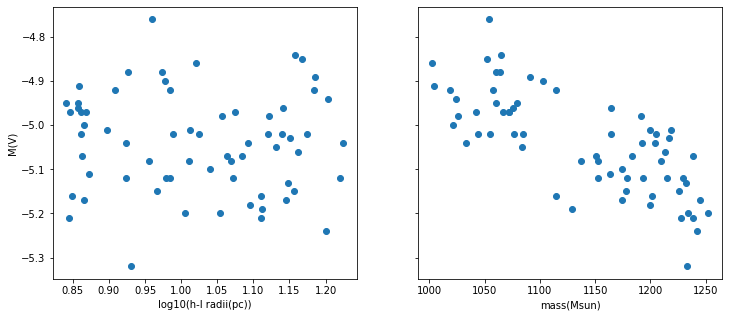

In [17]:
# TODO: Renomear essa função!
from gawa_simulations.plot import unnamed_plot
star_clusters_simulated = Path("results", "star_clusters_simulated.dat")
unnamed_plot(star_clusters_simulated)


In [ ]:
# Plot footprint map to check area.
from pathlib import Path
from gawa_simulations.plot import plot_ftp

hpx_ftp = Path("results", "ftp_4096_nest.fits")

# TODO: Estes parametros não são necessários se o JN for executado todo
mockcat = Path("results", "des_mockcat_for_detection.fits")
ra_min, ra_max = 45, 55  # 5., 85. # limits in ra of the simulated map
dec_min, dec_max = -30, -20  # -60., -20. # limits in dec of the simulated map

plot_ftp(hpx_ftp, star_clusters_simulated, mockcat, ra_max, ra_min, dec_min, dec_max)


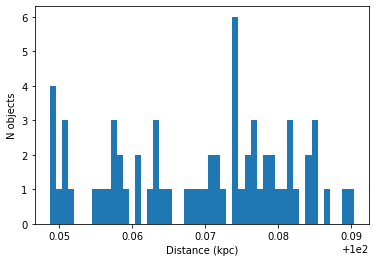

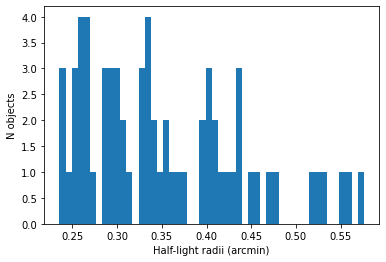

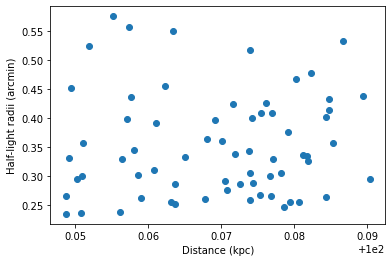

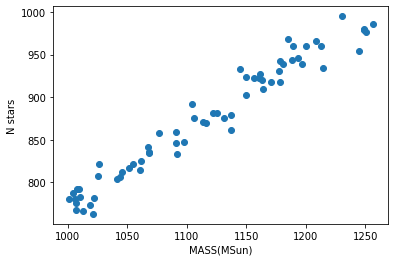

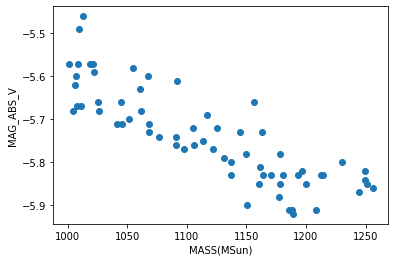

In [17]:
# Plots to analyze the simulated clusters.
from pathlib import Path
from gawa_simulations.plot import plots_ang_size

ftp_fits = Path("data", "ftp_4096_nest.fits")

# TODO: Estes parametros não são necessários se o JN for executado todo
star_clusters_simulated = Path("results", "star_clusters_simulated.dat")
mmin, mmax, cmin, cmax = 17.00, 24.00, -0.4, 1.6  # magnitude and color limits of stars
# Diretório onde estão os arquivo _clus.dat
clus_path = Path("results")
output_plots = Path("results/plots")
plots_ang_size(star_clusters_simulated, clus_path, mmin, mmax, cmin, cmax, output_plots)

# TODO: Seria interessante dividir essa função em duas
# Uma para os plots de _clus.dat
# Outra para os 4 plots do final.
# Dessa forma a geração dos plots _clus.dat poderia ser paralelizada.


In [1]:
# Plots to analyze the simulated clusters.
from pathlib import Path
from ga_sim.plot import plots_ref
import numpy as np

# TODO: Estes parametros não são necessários se o JN for executado todo
ftp_fits = Path("data", "ftp_4096_nest.fits")
star_clusters_simulated = Path("results", "star_clusters_simulated.dat")
output_plots = Path("results")

file_iso = Path("sample_data/iso_input2.dat")  # file with the isochrone
iso_info = np.loadtxt(file_iso, usecols=(1, 2), unpack=True)
FeH_iso = iso_info[0][0]

# Plots são gerados no diretório seria interessante aparecer aqui no JN
plots_ref(FeH_iso, star_clusters_simulated, output_plots)

Copying the main files to the folder where the Gawa code will be able to detect the simulated clusters.

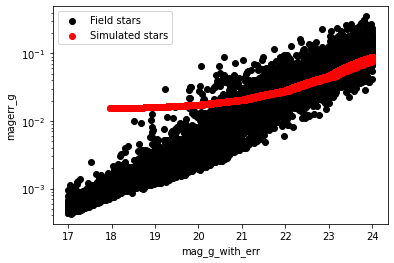

In [1]:
# Plots to analyze the simulated clusters.
from pathlib import Path
from ga_sim.plot import plot_err

mockcat = Path("results", "des_mockcat_for_detection.fits")
output_plots = Path("results")

plot_err(mockcat, output_plots)


In [1]:
# TODO: Esta função demora bastante, talves fosse interessante paralelisar 

# Remove Close Stars
from pathlib import Path
from ga_sim import remove_close_stars

mockcat = Path("results", "des_mockcat_for_detection.fits")
results_path = Path("results")
output_cat = Path(results_path, "des_mockcat_for_detection_wo_closest.fits")
nside_ini = 64
# def RemoveCloseStars(name_cat, output_cat, PSF_factor):

remove_close_stars(input_cat=mockcat, output_cat=output_cat, nside_ini=nside_ini)

# RemoveCloseStars('des_mockcat_for_detection.fits', 'des_mockcat_for_detection_wo_closest.fits', 1.0)

/home/glauber/linea/gawa_simulations/gawa_simulations/gawa.py:960: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if len(idx_[cond2]) == 0:


361501 300921


PosixPath('results/des_mockcat_for_detection_wo_closest.fits')